This tutorial reproduces the results of tutorial 20 on spinw.org. The exchange parameter values were obtained from " PRX 1 , 021002 (2011)".

Get Packages

In [5]:
using Sunny,GLMakie,CairoMakie

Define the lattice. Set up the lattice, the position of magnetic atoms, the symmetry inequivalent postions and the spin. In this case, there are 4 different atoms but only one of them (Yb+3) is magnetic. Only this atom has been considered for calculations. The position specified in SpinW corresponds to index 11 in Sunny. Again, correct indexixng is important. The space group is Fd-3m or 227. Note that a specific setting needs to be provided for Sunny to correctly recognize the system. The g-tensor value has also been obtained from the paper.

In [6]:
a = 10.0307
latvecs = lattice_vectors(a, a, a, 90, 90, 90)
positions=[[1/2, 1/2, 1/2]]
types=["A"]
cryst = Crystal(latvecs,positions,227;types,setting="2")
g_tensor=(-0.84)*[1 1 1;1 1 1;1 1 1]+4.32*[1 0 0; 0 1 0; 0 0 1]
view_crystal(cryst)
print_symmetry_table(cryst,8)
sys=System(cryst, (1,1,1),[SpinInfo(11,S=1/2,g=g_tensor)], :dipole, seed=0)

Atom 1
Type 'A', position [1/2, 0, 0], multiplicity 16
Allowed g-tensor: [A B B
                   B A B
                   B B A]
Allowed anisotropy in Stevens operators:
    c₁*(𝒪[2,-2]+2𝒪[2,-1]+2𝒪[2,1]) +
    c₂*(-7𝒪[4,-3]-2𝒪[4,-2]+𝒪[4,-1]+𝒪[4,1]+7𝒪[4,3]) + c₃*(𝒪[4,0]+5𝒪[4,4]) +
    c₄*(-11𝒪[6,-6]-8𝒪[6,-3]+𝒪[6,-2]-8𝒪[6,-1]-8𝒪[6,1]+8𝒪[6,3]) + c₅*(𝒪[6,0]-21𝒪[6,4]) + c₆*((9/5)𝒪[6,-6]+(24/5)𝒪[6,-5]+𝒪[6,-2]+(8/5)𝒪[6,-1]+(8/5)𝒪[6,1]+(24/5)𝒪[6,5])

Bond(1, 2, [0, 0, 0])
Distance 3.546387995024, coordination 6
Connects 'A' at [1/2, 0, 0] to 'A' at [3/4, 1/4, 0]
Allowed exchange matrix: [A C -D
                          C A -D
                          D D  B]
Allowed DM vector: [-D D 0]

Bond(1, 7, [0, 0, 0])
Distance 6.1425241907338, coordination 12
Connects 'A' at [1/2, 0, 0] to 'A' at [1/4, 1/2, 1/4]
Allowed exchange matrix: [  A  C-E  D-F
                          C+E    B -C+E
                          D+F -C-E    A]
Allowed DM vector: [E F -E]

Bond(1, 3, [0, 0, 0])
Distance 7.0927759

System [Dipole mode]
Lattice (1×1×1)×16
Energy per site 0


Set up the exchange and the Hamiltonian. Note that the exchange is anisotropic as compared to heisenberg in previous tutorials. Note that set_external_field! has been used to set up a field in the system. The tutorial on spinw has two fields, 2T and 5T, applied to the system.

In [7]:
J1 = -0.09; 
J2 = -0.22; 
J3 = -0.29; 
J4 = 0.01;

J_mat=[J2 J4 J4; 
       -J4 J1 J3; 
       -J4 J3 J1]

set_exchange!(sys,J_mat,Bond(1, 6, [0, 0, 0]))
Field=[5,2]

2-element Vector{Int64}:
 5
 2

Plot convoluted spectra on a 2x5 grid as given in the tutorial

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/bhushanthipe/.julia/packages/Makie/z2T2o/src/scenes.jl:220


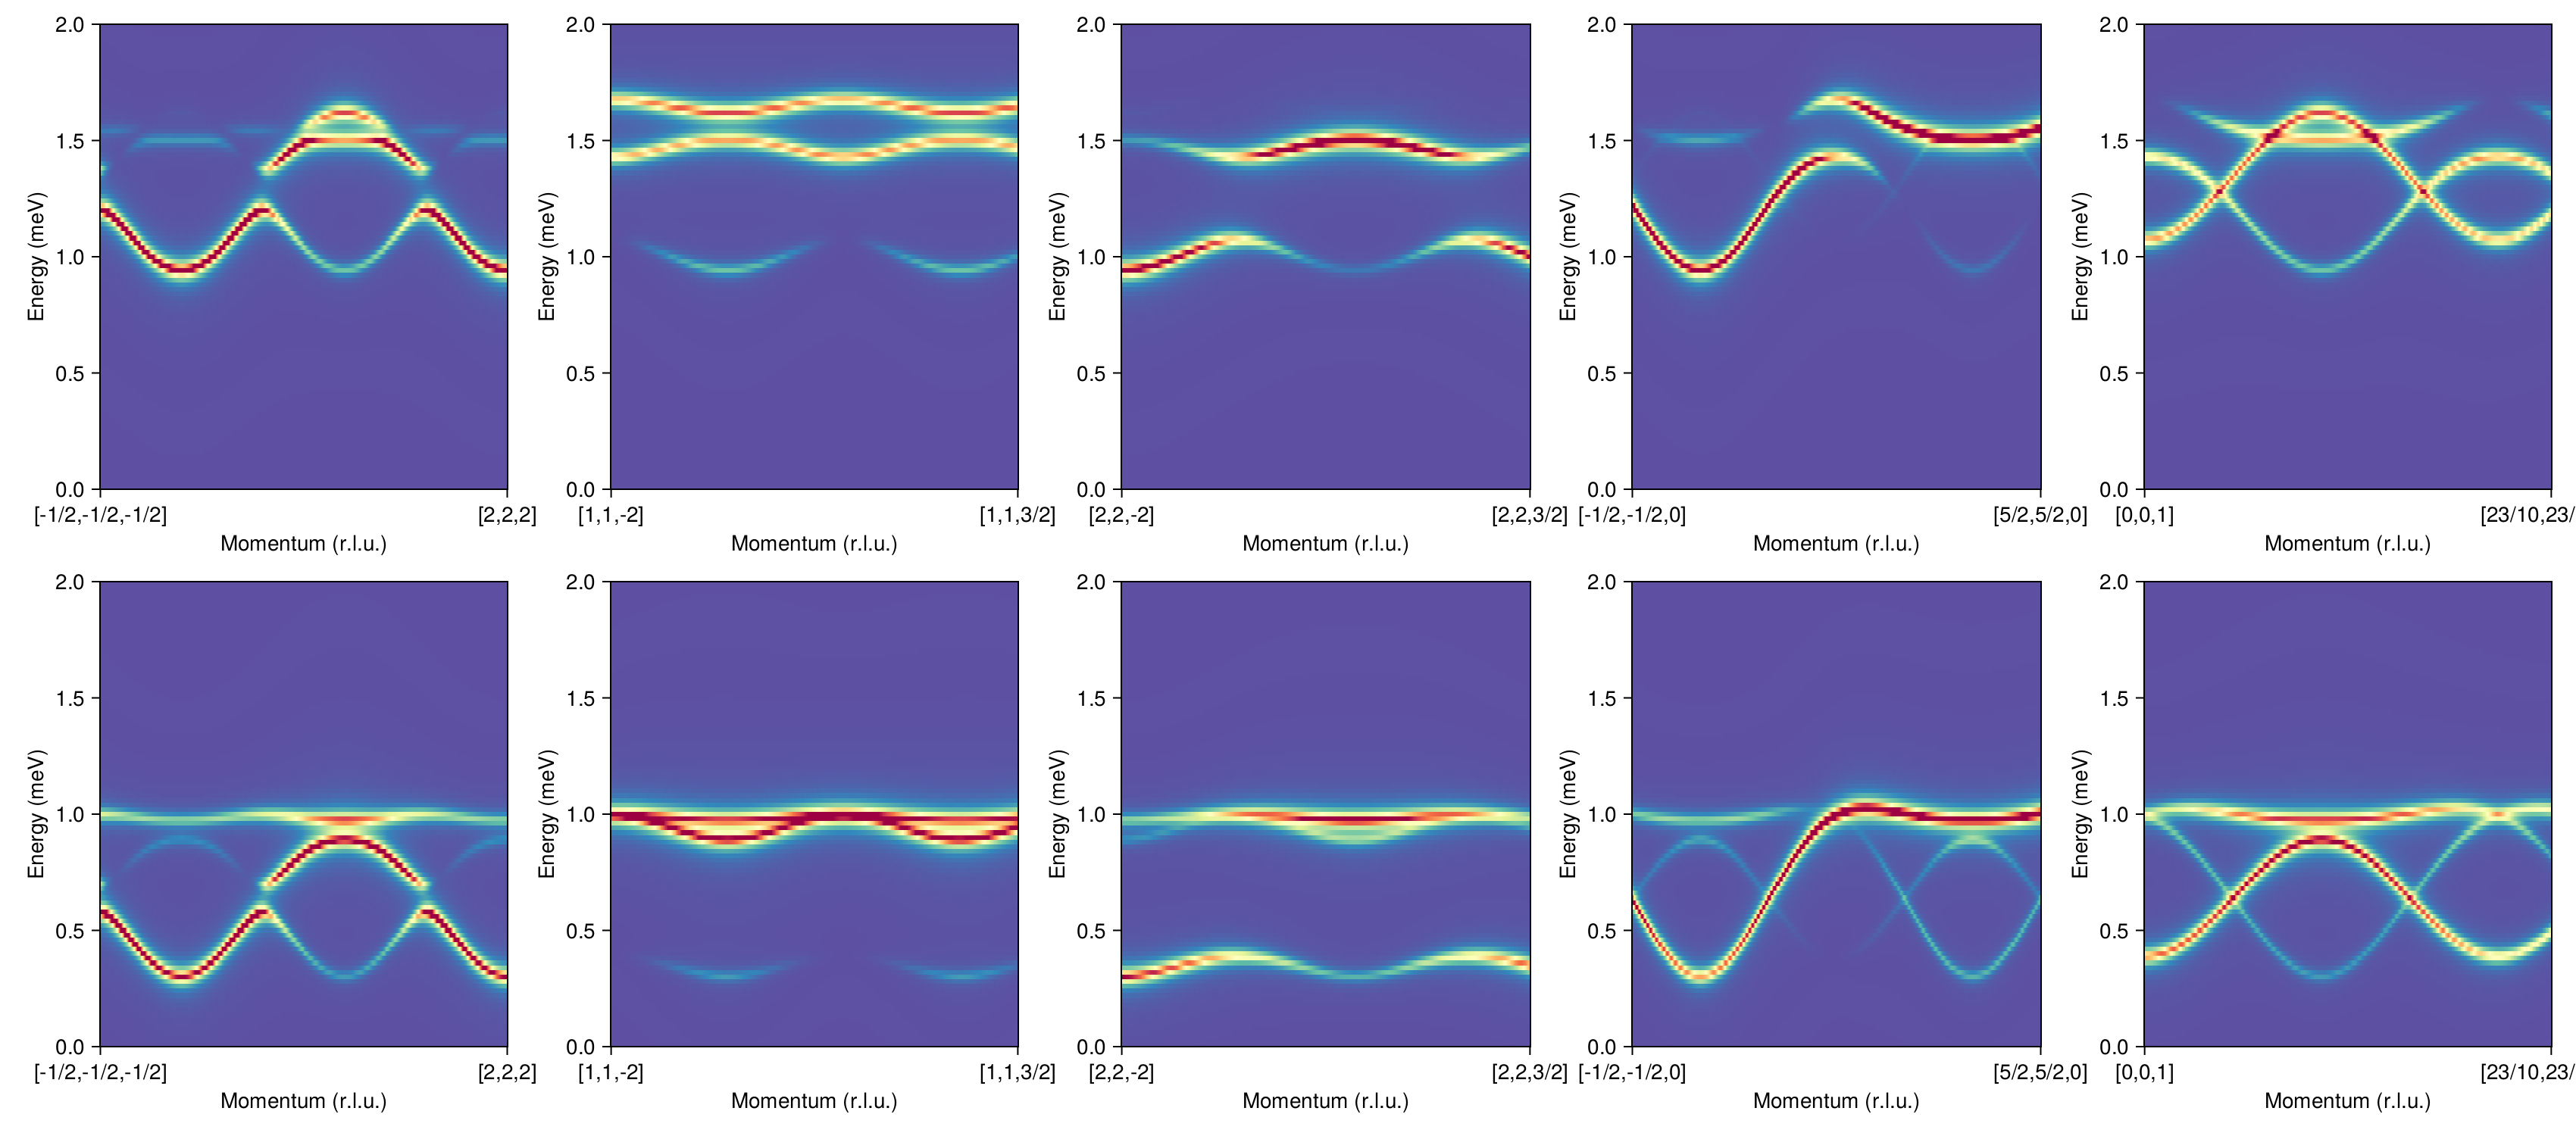

In [8]:
CairoMakie.activate!()
fig1 = Figure(resolution=(1700, 750))
for i in 1:length(Field)
    set_external_field!(sys,Field[i]*[1 -1 0]/sqrt(2))
    randomize_spins!(sys)
    minimize_energy!(sys)
    q_points=[[[-0.5,-0.5,-0.5],[2,2,2]],[[1,1,-2],[1,1,1.5]],[[2,2,-2],[2,2,1.5]],[[-0.5,-0.5,0],[2.5,2.5,0]],[[0,0,1],[2.3,2.3,1]]]
    for j in 1:length(q_points)
            density = 200
            path, xticks = reciprocal_space_path(cryst, q_points[j], density);
            swt = SpinWaveTheory(sys)
            formula = intensity_formula(swt, :perp; kernel=delta_function_kernel)
            disp, intensity = intensities_bands(swt, path, formula);
        
            γ = 0.02 
            broadened_formula = intensity_formula(swt, :perp; kernel=lorentzian(γ))
            energies = collect(0:0.02:12) 
            is = intensities_broadened(swt, path, energies, broadened_formula);
            ax = Axis(fig1[i,j]; xlabel="Momentum (r.l.u.)", ylabel="Energy (meV)", xticks)
            ylims!(ax, 0.0, 2.0)
            pl=heatmap!(ax, 1:size(is, 1), energies, is,color="black",colorrange=(0.0,3))
            pl.colormap = Reverse(:Spectral)
       
    end
end
fig1